In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [7]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [8]:
dog_data = pd.read_table('dog_data.txt')
chimp_data = pd.read_table('chimp_data.txt')
dog_data.head()


,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In [9]:
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [10]:
# sekans idizlerini k-mer yapılarına dönüştürme  (varsayılan boyut = 6)
def getKmers (sequence, size = 6):
    return [sequence[x:x+size].lower() for x in range(len(sequence)-size+1)]

In [11]:
human_data["words"] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)

chimp_data["words"] = chimp_data.apply(lambda x: getKmers(x['sequence']),axis = 1)
chimp_data = chimp_data.drop('sequence',axis = 1)

dog_data["words"] = dog_data.apply(lambda x : getKmers(x['sequence']),axis = 1)
dog_data = dog_data.drop('sequence',axis = 1)

In [12]:
# Burada Yaptığımız işlem nükleotidleri 6şarlı şekilde ayırmak ama her seferinde  1 nükleotit kayarak
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [13]:
#Scikit-learn doğal dil işleme araçlarını kullanarak k-mer sayımı yapacağımızdan, 
#her bir gen için k-mer listelerini sayım vektörleyicinin kullanabileceği kelime cümlelerine dönüştürmemiz gerekiyor.
human_texts = list(human_data["words"])

for item in range(len(human_texts)):
    human_texts[item] = " ".join(human_texts[item])

y_data = human_data.iloc[:,0].values
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [14]:
y_data  # değişkenleri tuttuk

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

In [15]:
dog_texts = list(dog_data["words"])

for item in range(len(dog_texts)):
    dog_texts[item] = " ".join(dog_texts[item])

y_dog = dog_data.iloc[:,0].values


In [16]:
chimp_texts = list(chimp_data["words"])

for item in range(len(chimp_texts)):
    chimp_texts[item] = " ".join(chimp_texts[item])

y_chimp = chimp_data.iloc[:,0].values


In [17]:
# CountVectorizer() kullanarak Kelime Çantası modelinin oluşturulması
# Bu k-mer sayımına eşdeğerdir
# 4'ün n-gram boyutu daha önce testlerle belirlendi
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


<Axes: xlabel='class'>

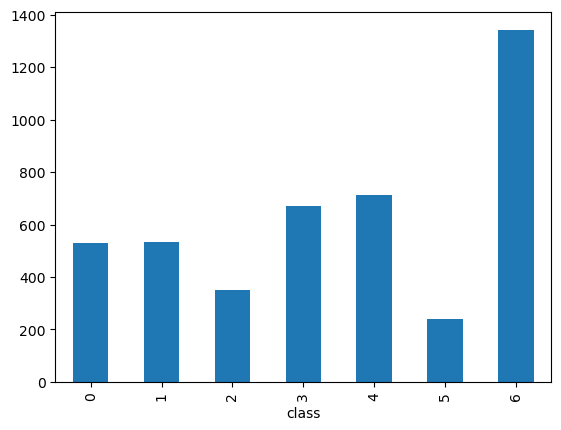

In [18]:
human_data["class"].value_counts().sort_index().plot.bar()

## Train  Test split

In [19]:
X_train , X_test , y_train , y_test = train_test_split(X,
                                                      y_data,
                                                      test_size=0.20,
                                                      random_state = 42)
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


 ## Multinomainal NB algoritması kurulumu

In [20]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train,y_train)


MultinomialNB(alpha=0.1)

In [21]:
y_pred = classifier.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
        accuracy = accuracy_score(y_test, y_predicted)
        precision = precision_score(y_test, y_predicted, average='weighted')
        recall = recall_score(y_test, y_predicted, average='weighted')
        f1 = f1_score(y_test, y_predicted, average='weighted')
        return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
